In [4]:
import numpy as np 
import pandas as pd

# Load Dataset

In [15]:
audio=pd.read_csv('/kaggle/input/shl-intern-hiring-assessment/dataset/train.csv')

In [3]:
audio.head()

,filename,label
0,audio_1261.wav,1.0
1,audio_942.wav,1.5
2,audio_1110.wav,1.5
3,audio_1024.wav,1.5
4,audio_538.wav,2.0


In [4]:
print(f"Training samples: {len(audio)}")

Training samples: 444


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')



# Visualizing the dataset

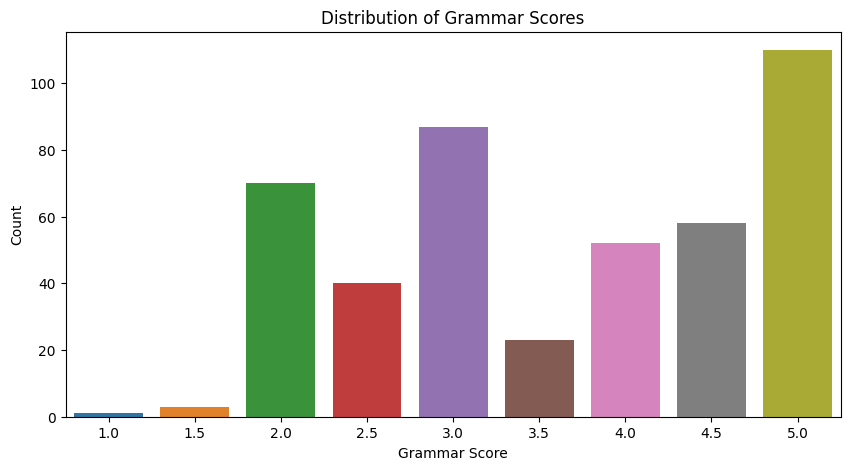

In [6]:
plt.figure(figsize=(10, 5))
sns.countplot(data=audio, x='label')
plt.title('Distribution of Grammar Scores')
plt.xlabel('Grammar Score')
plt.ylabel('Count')
plt.show()

In [16]:
import os
from tqdm import tqdm

audio_dir = '/kaggle/input/shl-intern-hiring-assessment/dataset/audios_train/'

durations = []

for file_name in tqdm(audio['filename']):
    file_path = os.path.join(audio_dir, file_name)
    y, sr = librosa.load(file_path, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    durations.append(duration)

durations = np.array(durations)

100%|██████████| 444/444 [00:05<00:00, 82.00it/s] 


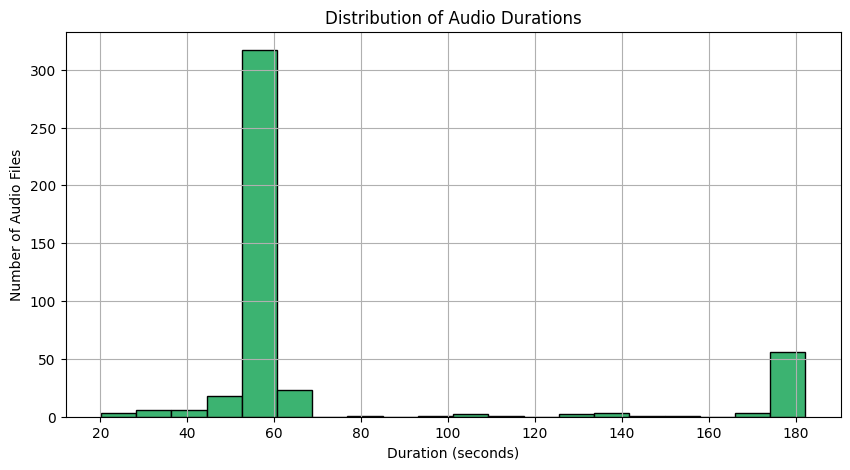

In [8]:
plt.figure(figsize=(10, 5))
plt.hist(durations, bins=20, color='mediumseagreen', edgecolor='black')
plt.title('Distribution of Audio Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Number of Audio Files')
plt.grid(True)
plt.show()


100%|██████████| 444/444 [00:04<00:00, 89.63it/s] 


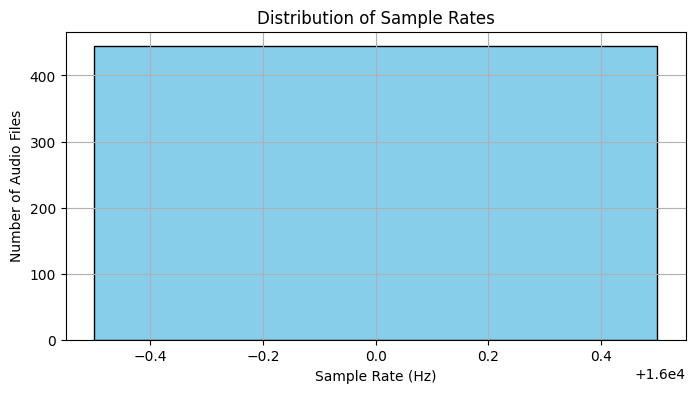

Unique sample rates found: [16000]


In [17]:
sample_rates = []

for file_name in tqdm(audio['filename']):
    file_path = os.path.join(audio_dir, file_name)
    _, sr = librosa.load(file_path, sr=None)  # Only care about sample rate
    sample_rates.append(sr)

sample_rates = np.array(sample_rates)

plt.figure(figsize=(8, 4))
plt.hist(sample_rates, bins=len(set(sample_rates)), color='skyblue', edgecolor='black')
plt.title('Distribution of Sample Rates')
plt.xlabel('Sample Rate (Hz)')
plt.ylabel('Number of Audio Files')
plt.grid(True)
plt.show()

print(f"Unique sample rates found: {np.unique(sample_rates)}")

# Visualizing (sample audio)-

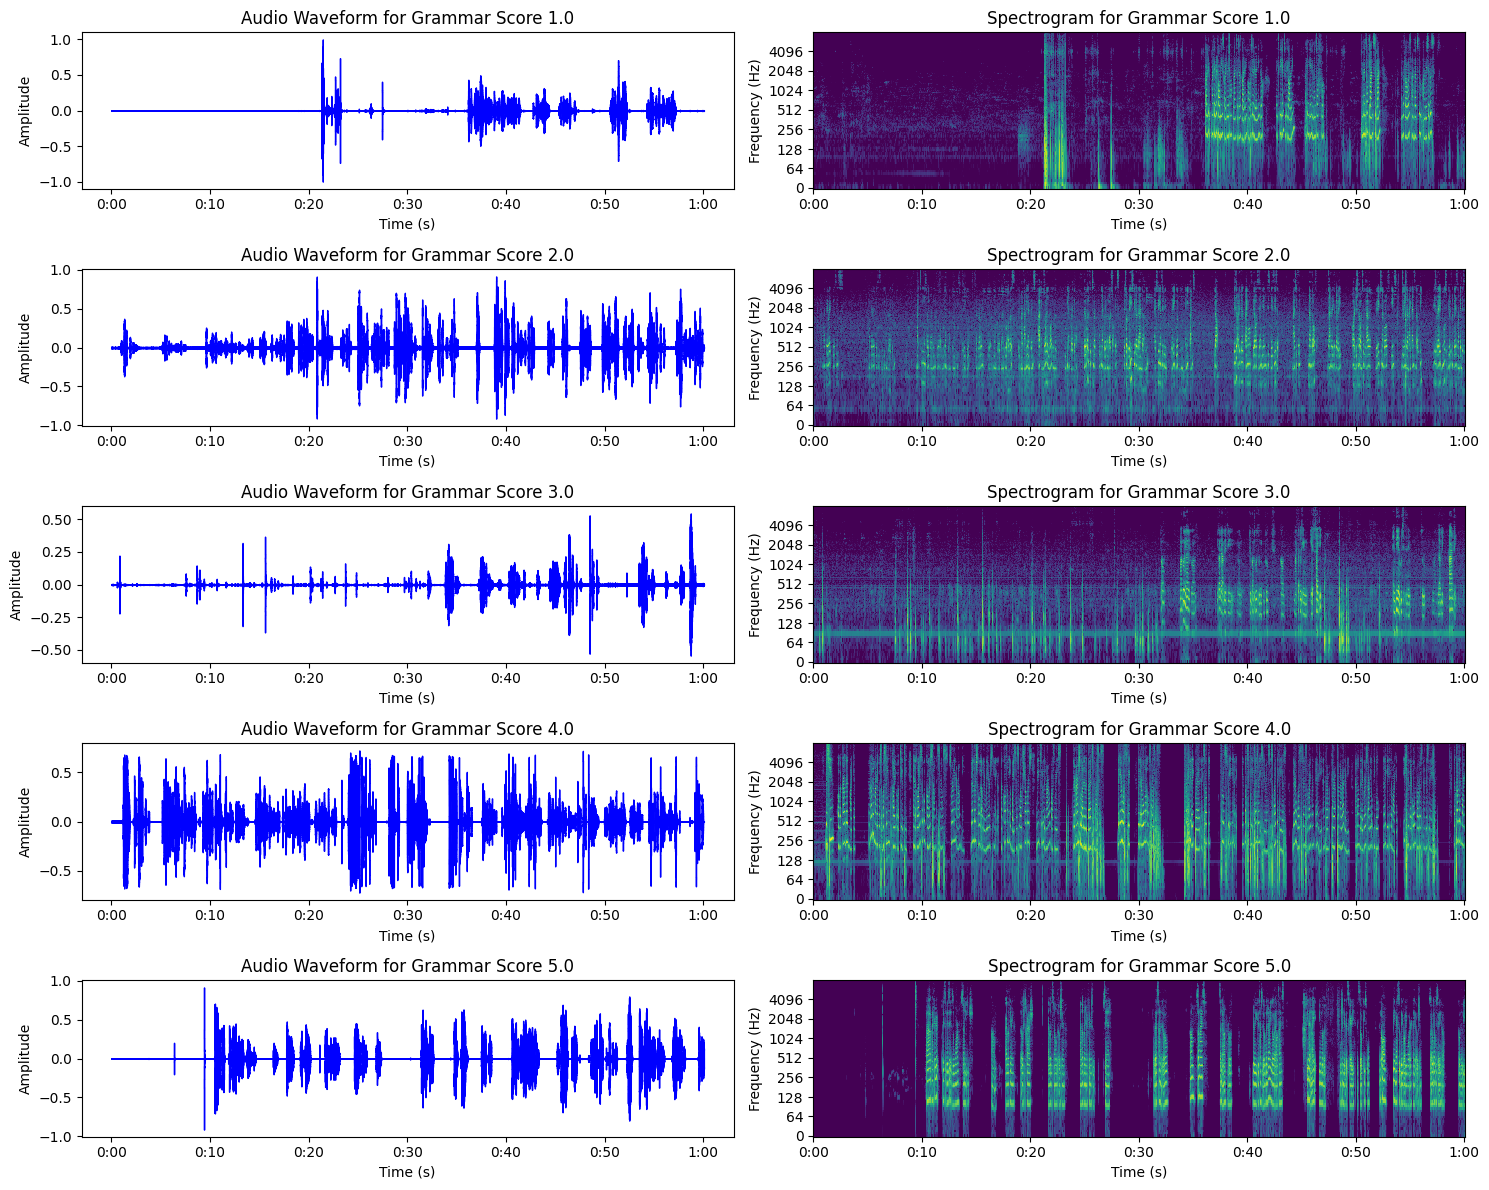

In [18]:
# Grammar scores to visualize
selected_scores = [1.0, 2.0, 3.0, 4.0, 5.0]

plt.figure(figsize=(15, 12))

for i, score in enumerate(selected_scores, 1):
    file_name = audio[audio['label'] == score]['filename'].iloc[0] 

    file_path = os.path.join(audio_dir, file_name)
    y, sr = librosa.load(file_path, sr=None)

    #Audio Waveform
    plt.subplot(5, 2, 2*i-1)  # 5 rows, 2 columns, left plot
    librosa.display.waveshow(y, sr=sr, color='b')
    plt.title(f'Audio Waveform for Grammar Score {score}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    #Spectrogram
    plt.subplot(5, 2, 2*i)  # 5 rows, 2 columns, right plot
    D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
    plt.title(f'Spectrogram for Grammar Score {score}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

# summary statistics

Audio Durations Statistics:
Mean Duration: 76.25 seconds
Median Duration: 60.07 seconds
Standard Deviation of Duration: 42.33 seconds

Sample Rates Statistics:
Mean Sample Rate: 16000.00 Hz
Median Sample Rate: 16000.00 Hz
Standard Deviation of Sample Rate: 0.00 Hz


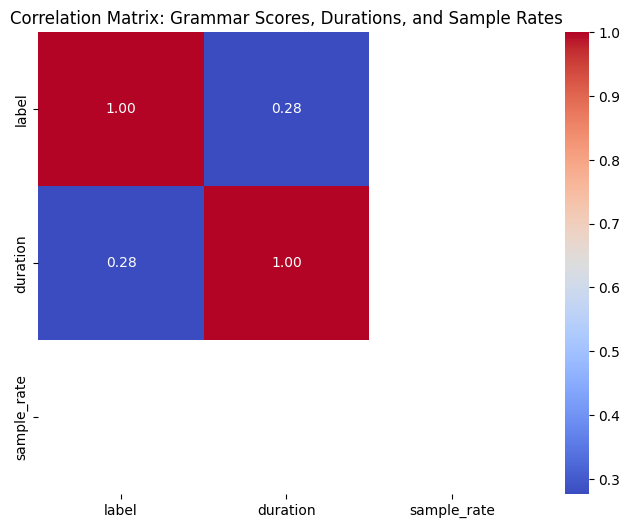


Correlation Matrix:
                label  duration  sample_rate
label        1.000000  0.276267          NaN
duration     0.276267  1.000000          NaN
sample_rate       NaN       NaN          NaN


In [19]:
duration_mean = np.mean(durations)
duration_median = np.median(durations)
duration_std = np.std(durations)

sample_rate_mean = np.mean(sample_rates)
sample_rate_median = np.median(sample_rates)
sample_rate_std = np.std(sample_rates)

print("Audio Durations Statistics:")
print(f"Mean Duration: {duration_mean:.2f} seconds")
print(f"Median Duration: {duration_median:.2f} seconds")
print(f"Standard Deviation of Duration: {duration_std:.2f} seconds")

print("\nSample Rates Statistics:")
print(f"Mean Sample Rate: {sample_rate_mean:.2f} Hz")
print(f"Median Sample Rate: {sample_rate_median:.2f} Hz")
print(f"Standard Deviation of Sample Rate: {sample_rate_std:.2f} Hz")

audio['duration'] = durations
audio['sample_rate'] = sample_rates

correlation_matrix = audio[['label', 'duration', 'sample_rate']].corr()

#correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix: Grammar Scores, Durations, and Sample Rates')
plt.show()

#correlation matrix
print("\nCorrelation Matrix:")
print(correlation_matrix)


In [12]:
class_counts = audio['label'].value_counts()
print(f"Class distribution:\n{class_counts}")


Class distribution:
label
5.0    110
3.0     87
2.0     70
4.5     58
4.0     52
2.5     40
3.5     23
1.5      3
1.0      1
Name: count, dtype: int64


# check outliner

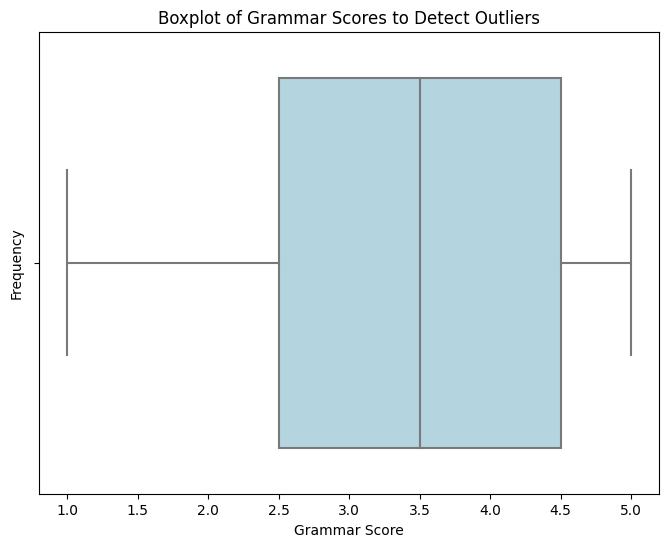

In [13]:
# Boxplot to check for outliers
plt.figure(figsize=(8, 6))
sns.boxplot(data=audio, x='label', color='lightblue')
plt.title('Boxplot of Grammar Scores to Detect Outliers')
plt.xlabel('Grammar Score')
plt.ylabel('Frequency')
plt.show()


# Checking Missing Value


In [14]:
audio.isnull().sum()

filename       0
label          0
duration       0
sample_rate    0
dtype: int64

no missing value present

# Extract features from audio

In [20]:
def extract_audio_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    
    # MFCCs(I took 13)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)
    
    # Chroma Feature
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    
    #Spectral Contrast
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spectral_contrast_mean = np.mean(spectral_contrast, axis=1)
    
    #Zero Crossing Rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
    zero_crossing_rate_mean = np.mean(zero_crossing_rate)
    
    # Root Mean Square Error (RMSE)
    rmse = librosa.feature.rms(y=y)
    rmse_mean = np.mean(rmse)
    
    #Spectral Rolloff
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)
    spectral_rolloff_mean = np.mean(spectral_rolloff)
    
    #Tempo
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)

    return [mfccs_mean, mfccs_std, chroma_mean, spectral_contrast_mean, 
            zero_crossing_rate_mean, rmse_mean, spectral_rolloff_mean, tempo]

audio_features = []
audio_dir = '/kaggle/input/shl-intern-hiring-assessment/dataset/audios_train/'

for file_name in tqdm(audio['filename']):
    file_path = os.path.join(audio_dir, file_name)
    features = extract_audio_features(file_path)
    audio_features.append(features)


100%|██████████| 444/444 [05:20<00:00,  1.38it/s]


In [21]:
audio_features_df = pd.DataFrame(audio_features, columns=['mfccs_mean', 'mfccs_std', 'chroma_mean', 
                                                          'spectral_contrast_mean', 'zero_crossing_rate_mean',
                                                          'rmse_mean', 'spectral_rolloff_mean', 'tempo'])

audio = pd.concat([audio, audio_features_df], axis=1)

In [22]:
audio.head()

,filename,label,duration,sample_rate,mfccs_mean,mfccs_std,chroma_mean,spectral_contrast_mean,zero_crossing_rate_mean,rmse_mean,spectral_rolloff_mean,tempo
0,audio_1261.wav,1.0,60.074688,16000,"[-485.99274, 50.11182, 8.837244, 9.500427, 1.9...","[127.46626, 46.62133, 27.924675, 21.501719, 15...","[0.45870534, 0.41125953, 0.41076368, 0.3850703...","[16.695766243577523, 14.350628137715406, 17.35...",0.143139,0.015064,3517.925486,[110.29411764705883]
1,audio_942.wav,1.5,60.074688,16000,"[-418.86237, 24.498125, 0.9830819, 3.57754, -1...","[134.78601, 41.811954, 17.726648, 17.736914, 2...","[0.32546762, 0.30135542, 0.24270165, 0.2000109...","[16.49503135937912, 16.713446770511734, 18.679...",0.105385,0.037655,3678.718218,[156.25]
2,audio_1110.wav,1.5,60.074688,16000,"[-468.62198, 55.77344, -6.867956, 12.415868, 2...","[139.22043, 66.77189, 25.078009, 22.193378, 12...","[0.42997012, 0.46307826, 0.4208494, 0.38261276...","[19.035255211251716, 14.351624610598737, 16.60...",0.132682,0.021168,3834.469016,[125.0]
3,audio_1024.wav,1.5,60.074688,16000,"[-395.97574, 83.70689, -9.338621, 22.242302, 2...","[152.25404, 68.29327, 32.15485, 30.071775, 15....","[0.36008617, 0.33294824, 0.30505034, 0.2743879...","[22.608028220053328, 15.916210041009137, 18.09...",0.094663,0.041441,2438.423522,[125.0]
4,audio_538.wav,2.0,60.074688,16000,"[-300.15067, 104.44231, -19.612244, 7.2216325,...","[74.38069, 35.9127, 27.408539, 29.551165, 18.9...","[0.5372107, 0.48153827, 0.39005336, 0.37216085...","[17.225132536536318, 16.097057463016533, 18.04...",0.136809,0.043016,2949.576511,[125.0]


In [18]:
pecific_mfcc_values = audio.loc[0, 'mfccs_mean']
pecific_mfcc_values

array([-485.99274  ,   50.11182  ,    8.837244 ,    9.500427 ,
          1.9732225,    2.533967 ,   -6.8117833,    1.5878607,
         -4.8289466,   -3.5663486,   -2.6805975,   -2.6837208,
         -2.3764887], dtype=float32)

In [19]:
audio.isnull().sum()

filename                   0
label                      0
duration                   0
sample_rate                0
mfccs_mean                 0
mfccs_std                  0
chroma_mean                0
spectral_contrast_mean     0
zero_crossing_rate_mean    0
rmse_mean                  0
spectral_rolloff_mean      0
tempo                      0
dtype: int64

In [20]:
audio.shape

(444, 12)

# Visualising the feature extration


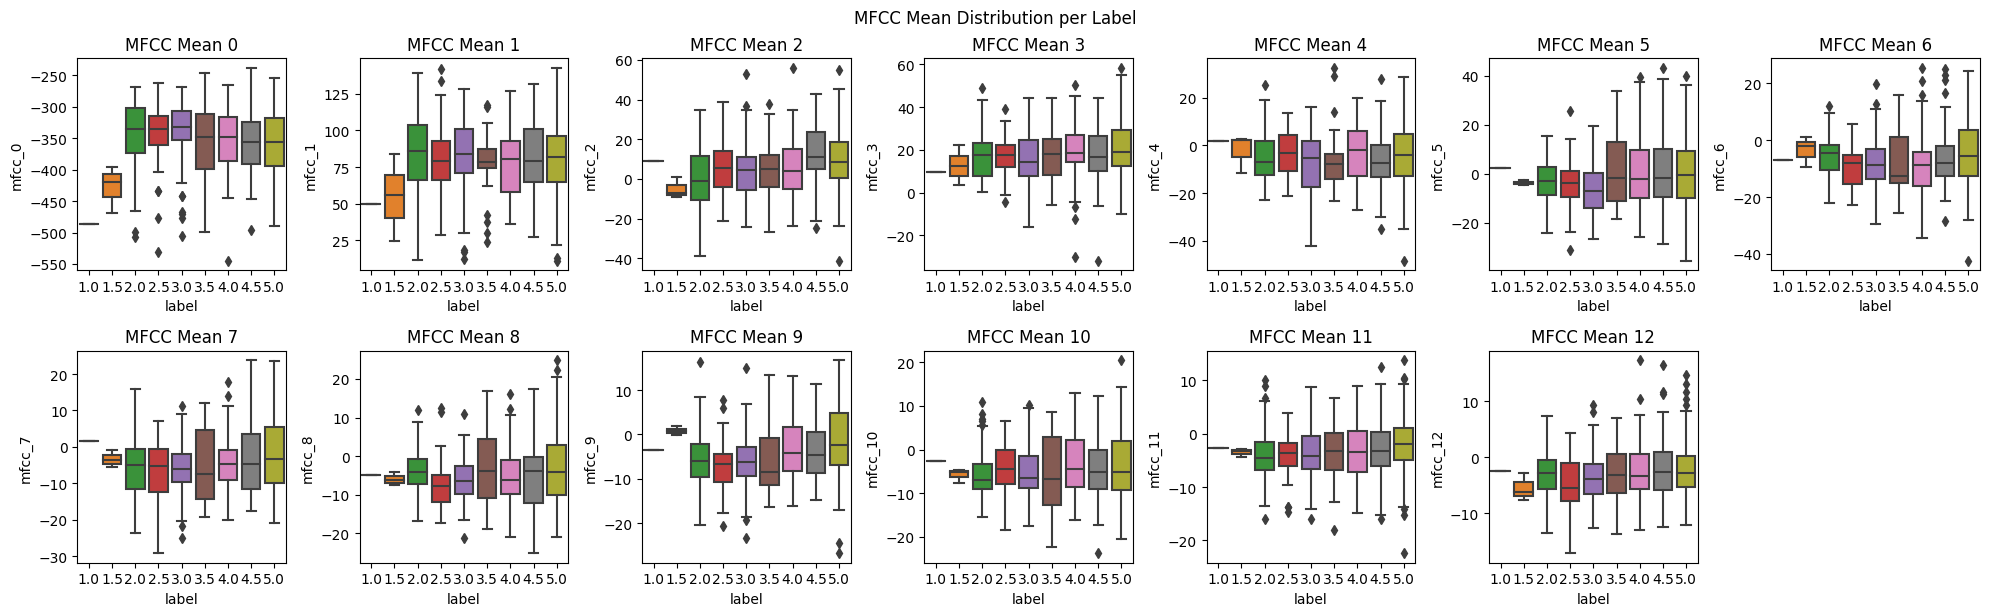

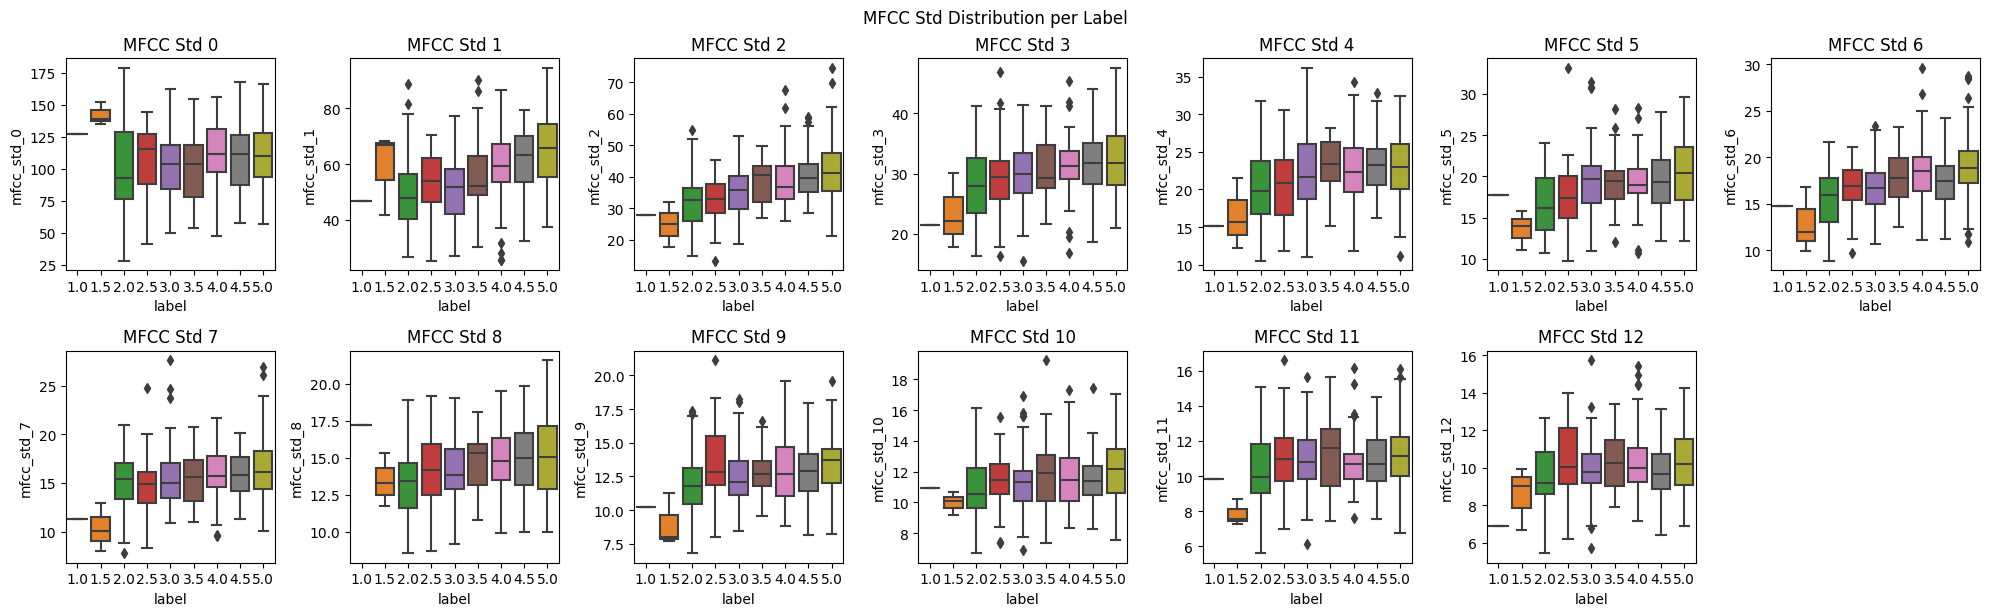

In [21]:
mfccs_mean_df = pd.DataFrame(audio['mfccs_mean'].tolist()).add_prefix('mfcc_')
mfccs_std_df = pd.DataFrame(audio['mfccs_std'].tolist()).add_prefix('mfcc_std_')

mfccs_mean_df['label'] = audio['label']
mfccs_std_df['label'] = audio['label']

#MFCC means
plt.figure(figsize=(20, 6))
for i in range(13):
    plt.subplot(2, 7, i+1)
    sns.boxplot(x='label', y=f'mfcc_{i}', data=mfccs_mean_df)
    plt.title(f'MFCC Mean {i}')
    plt.tight_layout()
plt.suptitle("MFCC Mean Distribution per Label", y=1.02)
plt.show()

#MFCC stds
plt.figure(figsize=(20, 6))
for i in range(13):
    plt.subplot(2, 7, i+1)
    sns.boxplot(x='label', y=f'mfcc_std_{i}', data=mfccs_std_df)
    plt.title(f'MFCC Std {i}')
    plt.tight_layout()
plt.suptitle("MFCC Std Distribution per Label", y=1.02)
plt.show()


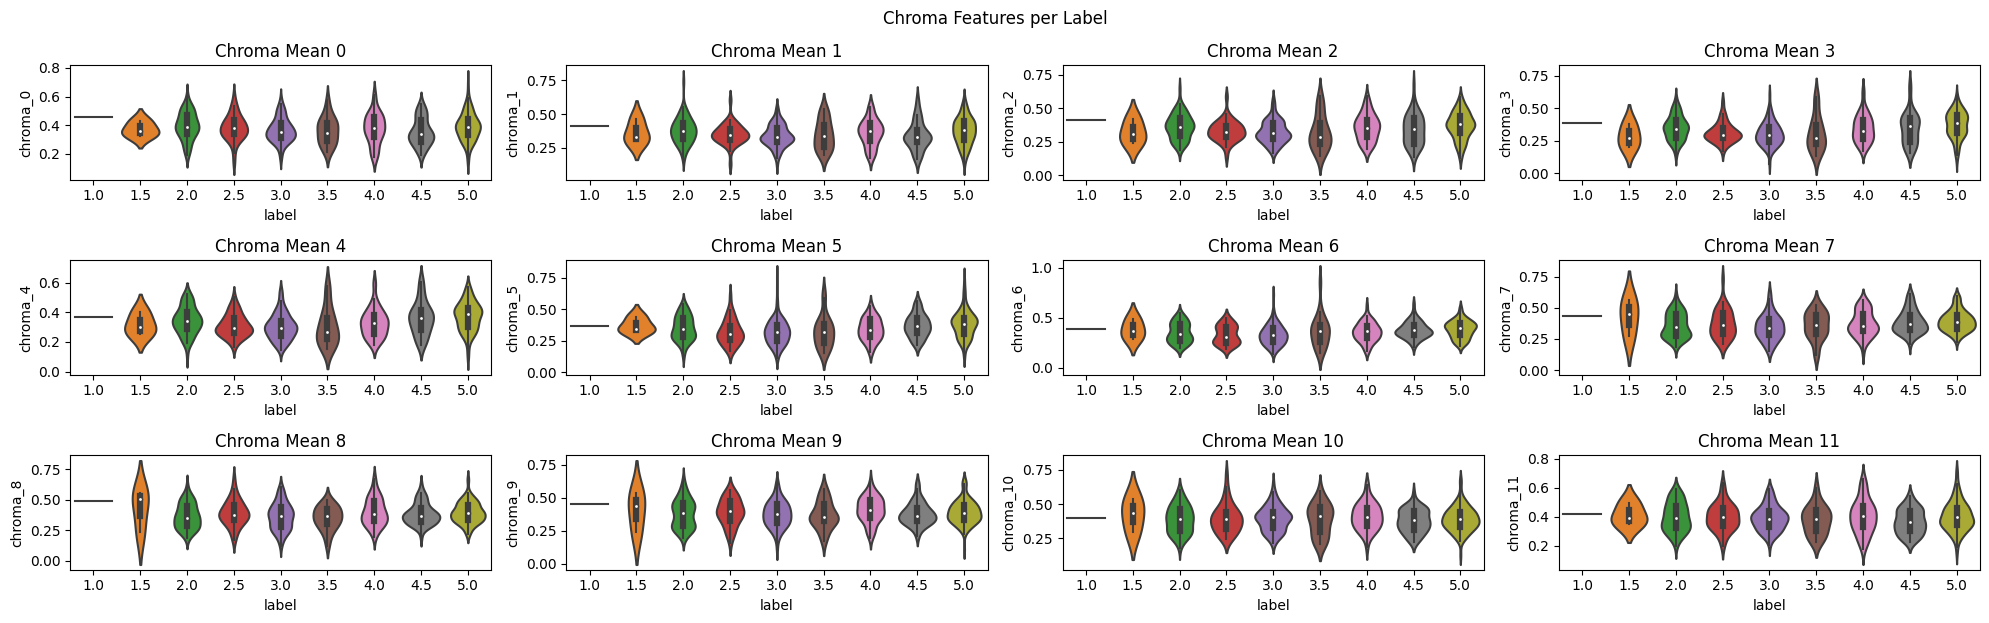

In [22]:
chroma_df = pd.DataFrame(audio['chroma_mean'].tolist()).add_prefix('chroma_')
chroma_df['label'] = audio['label']

plt.figure(figsize=(20, 6))
for i in range(12):
    plt.subplot(3, 4, i+1)
    sns.violinplot(x='label', y=f'chroma_{i}', data=chroma_df)
    plt.title(f'Chroma Mean {i}')
    plt.tight_layout()
plt.suptitle("Chroma Features per Label", y=1.03)
plt.show()


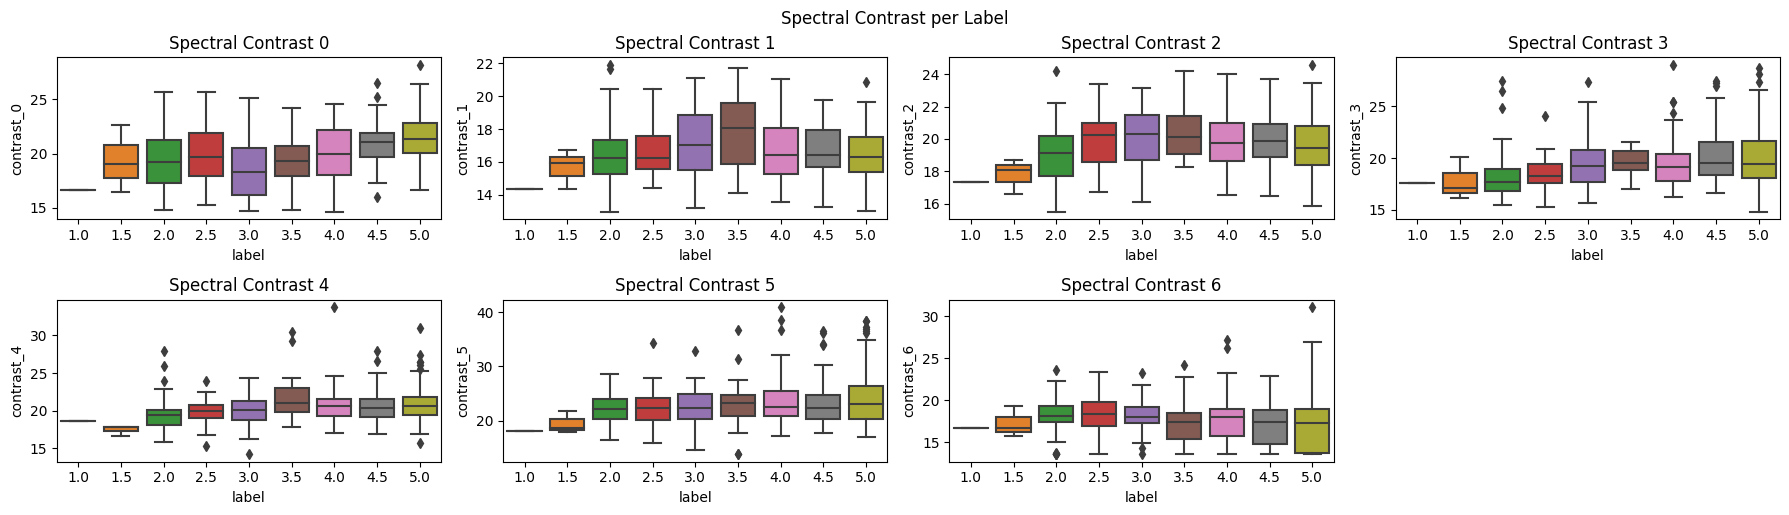

In [23]:
contrast_df = pd.DataFrame(audio['spectral_contrast_mean'].tolist()).add_prefix('contrast_')
contrast_df['label'] = audio['label']

plt.figure(figsize=(18, 5))
for i in range(7):  # Typically 7 bands for spectral contrast
    plt.subplot(2, 4, i+1)
    sns.boxplot(x='label', y=f'contrast_{i}', data=contrast_df)
    plt.title(f'Spectral Contrast {i}')
    plt.tight_layout()
plt.suptitle("Spectral Contrast per Label", y=1.02)
plt.show()


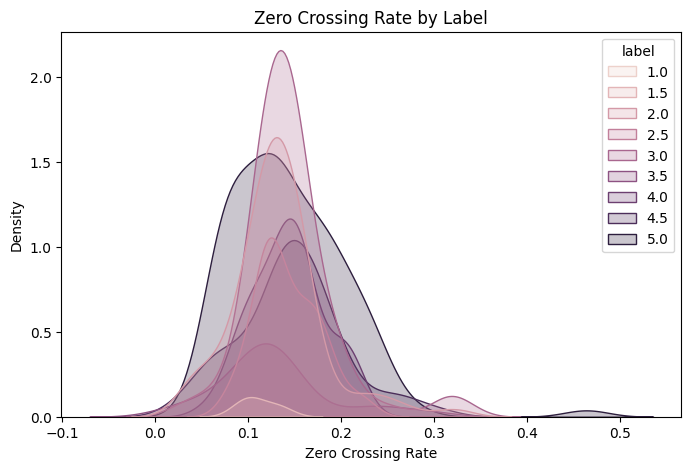

In [24]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=audio, x='zero_crossing_rate_mean', hue='label', fill=True)
plt.title('Zero Crossing Rate by Label')
plt.xlabel('Zero Crossing Rate')
plt.ylabel('Density')
plt.show()


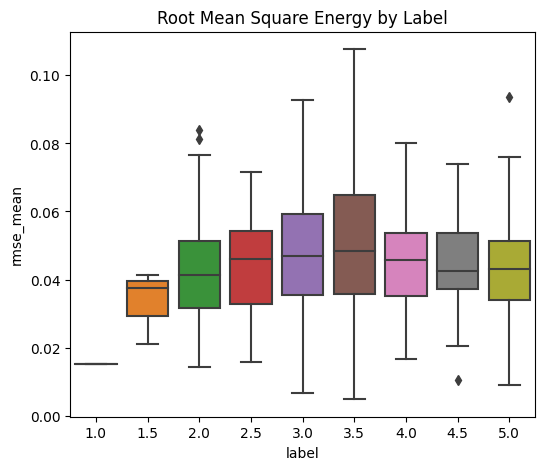

In [25]:
plt.figure(figsize=(6, 5))
sns.boxplot(x='label', y='rmse_mean', data=audio)
plt.title('Root Mean Square Energy by Label')
plt.show()

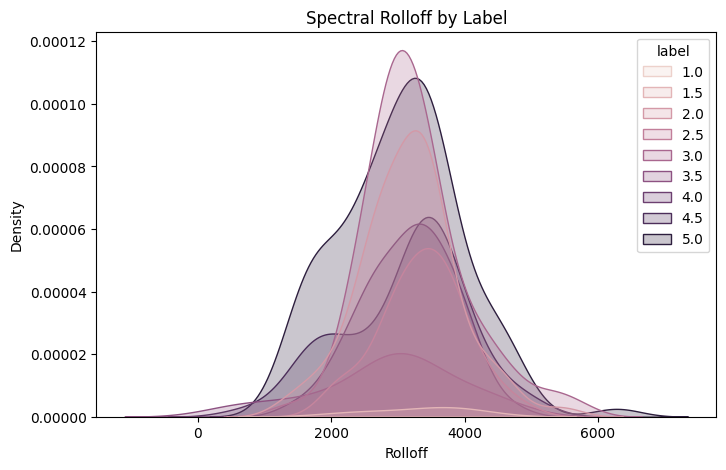

In [26]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=audio, x='spectral_rolloff_mean', hue='label', fill=True)
plt.title('Spectral Rolloff by Label')
plt.xlabel('Rolloff')
plt.ylabel('Density')
plt.show()


In [23]:
audioc=audio.copy()

In [123]:
audioc.head()

,filename,label,duration,sample_rate,mfccs_mean,mfccs_std,chroma_mean,spectral_contrast_mean,zero_crossing_rate_mean,rmse_mean,spectral_rolloff_mean,tempo
0,audio_1261.wav,1.0,60.074688,16000,"[-485.99274, 50.11182, 8.837244, 9.500427, 1.9...","[127.46626, 46.62133, 27.924675, 21.501719, 15...","[0.45870534, 0.41125953, 0.41076368, 0.3850703...","[16.695766243577523, 14.350628137715406, 17.35...",0.143139,0.015064,3517.925486,[110.29411764705883]
1,audio_942.wav,1.5,60.074688,16000,"[-418.86237, 24.498125, 0.9830819, 3.57754, -1...","[134.78601, 41.811954, 17.726648, 17.736914, 2...","[0.32546762, 0.30135542, 0.24270165, 0.2000109...","[16.49503135937912, 16.713446770511734, 18.679...",0.105385,0.037655,3678.718218,[156.25]
2,audio_1110.wav,1.5,60.074688,16000,"[-468.62198, 55.77344, -6.867956, 12.415868, 2...","[139.22043, 66.77189, 25.078009, 22.193378, 12...","[0.42997012, 0.46307826, 0.4208494, 0.38261276...","[19.035255211251716, 14.351624610598737, 16.60...",0.132682,0.021168,3834.469016,[125.0]
3,audio_1024.wav,1.5,60.074688,16000,"[-395.97574, 83.70689, -9.338621, 22.242302, 2...","[152.25404, 68.29327, 32.15485, 30.071775, 15....","[0.36008617, 0.33294824, 0.30505034, 0.2743879...","[22.608028220053328, 15.916210041009137, 18.09...",0.094663,0.041441,2438.423522,[125.0]
4,audio_538.wav,2.0,60.074688,16000,"[-300.15067, 104.44231, -19.612244, 7.2216325,...","[74.38069, 35.9127, 27.408539, 29.551165, 18.9...","[0.5372107, 0.48153827, 0.39005336, 0.37216085...","[17.225132536536318, 16.097057463016533, 18.04...",0.136809,0.043016,2949.576511,[125.0]


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = audioc.drop(columns=['filename', 'label'])
y = audioc['label']


In [25]:
X.isnull().sum()

duration                   0
sample_rate                0
mfccs_mean                 0
mfccs_std                  0
chroma_mean                0
spectral_contrast_mean     0
zero_crossing_rate_mean    0
rmse_mean                  0
spectral_rolloff_mean      0
tempo                      0
dtype: int64

In [26]:
X.columns

Index(['duration', 'sample_rate', 'mfccs_mean', 'mfccs_std', 'chroma_mean',
       'spectral_contrast_mean', 'zero_crossing_rate_mean', 'rmse_mean',
       'spectral_rolloff_mean', 'tempo'],
      dtype='object')

In [27]:
# Check the data types of the columns
print(X.dtypes)

duration                   float64
sample_rate                  int64
mfccs_mean                  object
mfccs_std                   object
chroma_mean                 object
spectral_contrast_mean      object
zero_crossing_rate_mean    float64
rmse_mean                  float32
spectral_rolloff_mean      float64
tempo                       object
dtype: object


In [28]:
def expand_column(df, col_name):
    return pd.DataFrame(df[col_name].tolist(), index=df.index).add_prefix(col_name + "_")

audioc_expanded = pd.concat([
    expand_column(audioc, 'mfccs_mean'),
    expand_column(audioc, 'mfccs_std'),
    expand_column(audioc, 'chroma_mean'),
    expand_column(audioc, 'spectral_contrast_mean'),
], axis=1)

scalar_cols = ['zero_crossing_rate_mean', 'rmse_mean', 'spectral_rolloff_mean', 'duration', 'sample_rate', 'label']

audioc_final = pd.concat([audioc_expanded, audioc[scalar_cols]], axis=1)

In [29]:
audioc_final.head()

,mfccs_mean_0,mfccs_mean_1,mfccs_mean_2,mfccs_mean_3,mfccs_mean_4,mfccs_mean_5,mfccs_mean_6,mfccs_mean_7,mfccs_mean_8,mfccs_mean_9,...,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,zero_crossing_rate_mean,rmse_mean,spectral_rolloff_mean,duration,sample_rate,label
0,-485.992737,50.111820,8.837244,9.500427,1.973222,2.533967,-6.811783,1.587861,-4.828947,-3.566349,...,17.630617,18.583574,18.075463,16.675982,0.143139,0.015064,3517.925486,60.074688,16000,1.0
1,-418.862366,24.498125,0.983082,3.577540,-11.690801,-2.484139,-9.580399,-0.941148,-7.578836,1.941515,...,20.099676,17.861927,17.801883,19.250162,0.105385,0.037655,3678.718218,60.074688,16000,1.5
2,-468.621979,55.773441,-6.867956,12.415868,2.657126,-3.901442,-1.949762,-3.627632,-3.994594,0.676666,...,16.152577,16.687588,18.702743,15.731226,0.132682,0.021168,3834.469016,60.074688,16000,1.5
3,-395.975739,83.706886,-9.338621,22.242302,2.223831,-4.640110,0.991509,-5.542060,-6.253079,-0.231806,...,17.068336,17.868670,21.782628,16.625504,0.094663,0.041441,2438.423522,60.074688,16000,1.5
4,-300.150665,104.442307,-19.612244,7.221632,-6.562626,-9.136395,-10.110367,-10.232144,-5.131830,-7.595556,...,16.133826,18.481421,22.895865,18.677242,0.136809,0.043016,2949.576511,60.074688,16000,2.0


# Normalization

In [30]:
from sklearn.preprocessing import StandardScaler

# Separate features and label
X = audioc_final.drop('label', axis=1)
y = audioc_final['label']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [31]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight


# Function to calculate evaluation metrics 

In [33]:
def evaluate_model(y_true, y_pred):
    #Pearson Correlation
    corr, _ = pearsonr(y_true, y_pred)
    
    #R-squared
    r2 = r2_score(y_true, y_pred)
    
    #MAE
    mae = mean_absolute_error(y_true, y_pred)
    
    #RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    #MSE
    mse = mean_squared_error(y_true, y_pred)
    
    #MAPE
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f'Pearson Correlation: {corr}')
    print(f'R-squared: {r2}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape}')

# Training the model(without balancing the data)

In [34]:
#  RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("\nRandom Forest Evaluation:")
evaluate_model(y_test, rf_pred)


Random Forest Evaluation:
Pearson Correlation: 0.6125972946053566
R-squared: 0.3615841861542025
Mean Absolute Error (MAE): 0.7713483146067415
Root Mean Squared Error (RMSE): 0.9328749208642754
Mean Squared Error (MSE): 0.870255617977528
Mean Absolute Percentage Error (MAPE): 25.774295523452828


In [32]:
# XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

print("\nXGBoost Evaluation:")
evaluate_model(y_test, xgb_pred)


XGBoost Evaluation:
Pearson Correlation: 0.5879889838326748
R-squared: 0.3435582883333229
Mean Absolute Error (MAE): 0.7198764661724648
Root Mean Squared Error (RMSE): 0.945953273274053
Mean Squared Error (MSE): 0.8948275952178951
Mean Absolute Percentage Error (MAPE): 23.97438251400283


In [33]:
# GradientBoostingRegressor
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

print("\nGradient Boosting Evaluation:")
evaluate_model(y_test, gb_pred)


Gradient Boosting Evaluation:
Pearson Correlation: 0.5800280807403462
R-squared: 0.33379990279150373
Mean Absolute Error (MAE): 0.7549102015789428
Root Mean Squared Error (RMSE): 0.9529584066121822
Mean Squared Error (MSE): 0.9081297247328293
Mean Absolute Percentage Error (MAPE): 25.492145382514046


In [35]:
#use GridSearchCV for hyperparameter tuning (on RandomForest)
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, 30]}
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_
best_rf_pred = best_rf_model.predict(X_test)

print("\nBest Random Forest Evaluation (after GridSearchCV):")
evaluate_model(y_test, best_rf_pred)


Best Random Forest Evaluation (after GridSearchCV):
Pearson Correlation: 0.6335261705015887
R-squared: 0.3828194645751333
Mean Absolute Error (MAE): 0.7582303370786517
Root Mean Squared Error (RMSE): 0.9172288580773544
Mean Squared Error (MSE): 0.8413087780898876
Mean Absolute Percentage Error (MAPE): 25.488093008739078


In [36]:
# use GridSearchCV for hyperparameter tuning (for XGBoost)
param_grid_xgb = {
    'n_estimators': [50, 0, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3]
}

grid_search_xgb = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
                               param_grid=param_grid_xgb, cv=5, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)
best_xgb_model = grid_search_xgb.best_estimator_
best_xgb_pred = best_xgb_model.predict(X_test)

print("\nBest XGBoost Model Evaluation (after GridSearchCV):")
evaluate_model(y_test, best_xgb_pred)



Best XGBoost Model Evaluation (after GridSearchCV):
Pearson Correlation: 0.5609560756088569
R-squared: 0.3060759739932959
Mean Absolute Error (MAE): 0.8040419214227227
Root Mean Squared Error (RMSE): 0.9725849881879232
Mean Squared Error (MSE): 0.9459215592485026
Mean Absolute Percentage Error (MAPE): 27.54467817706732


# Mode Training (Balancing the data using class weighting)

In [37]:
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [38]:
# RandomForestRegressor with sample weights
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train, sample_weight=sample_weights)
rf_pred = rf_model.predict(X_test)

print("\nRandom Forest Evaluation:")
evaluate_model(y_test, rf_pred)


Random Forest Evaluation:
Pearson Correlation: 0.6465466223685554
R-squared: 0.39236244269506837
Mean Absolute Error (MAE): 0.7571348314606742
Root Mean Squared Error (RMSE): 0.9101100377970108
Mean Squared Error (MSE): 0.8283002808988765
Mean Absolute Percentage Error (MAPE): 25.641323345817728


In [39]:
# XGBoost with sample weights
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train, sample_weight=sample_weights)
xgb_pred = xgb_model.predict(X_test)

print("\nXGBoost Evaluation:")
evaluate_model(y_test, xgb_pred)


XGBoost Evaluation:
Pearson Correlation: 0.5934454975711935
R-squared: 0.3390442630497872
Mean Absolute Error (MAE): 0.7216822377751383
Root Mean Squared Error (RMSE): 0.949200127701728
Mean Squared Error (MSE): 0.9009808824289768
Mean Absolute Percentage Error (MAPE): 25.184544530679393


In [40]:
#GradientBoostingRegressor with sample weights
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train, sample_weight=sample_weights)
gb_pred = gb_model.predict(X_test)

print("\nGradient Boosting Evaluation:")
evaluate_model(y_test, gb_pred)


Gradient Boosting Evaluation:
Pearson Correlation: 0.5880351397912688
R-squared: 0.3453149576725809
Mean Absolute Error (MAE): 0.7544036666271096
Root Mean Squared Error (RMSE): 0.944686717320013
Mean Squared Error (MSE): 0.8924329938808622
Mean Absolute Percentage Error (MAPE): 24.857679764337675


In [41]:
#use GridSearchCV for hyperparameter tuning (for RandomForest)
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, 30]}
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train, sample_weight=sample_weights)
best_rf_model = grid_search.best_estimator_
best_rf_pred = best_rf_model.predict(X_test)

print("\nBest Random Forest Evaluation (after GridSearchCV):")
evaluate_model(y_test, best_rf_pred)


Best Random Forest Evaluation (after GridSearchCV):
Pearson Correlation: 0.6479918308105002
R-squared: 0.39474389847186864
Mean Absolute Error (MAE): 0.7501404494382021
Root Mean Squared Error (RMSE): 0.9083248333107429
Mean Squared Error (MSE): 0.8250540028089888
Mean Absolute Percentage Error (MAPE): 25.455495362939185


In [42]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_rf_model, X_train, y_train, scoring='r2', cv=5)
print(f'Cross-Validated R2 scores: {cv_scores}')
print(f'Mean R2: {cv_scores.mean()}')

Cross-Validated R2 scores: [0.35197367 0.43400046 0.34230271 0.29237739 0.43466573]
Mean R2: 0.3710639926259908


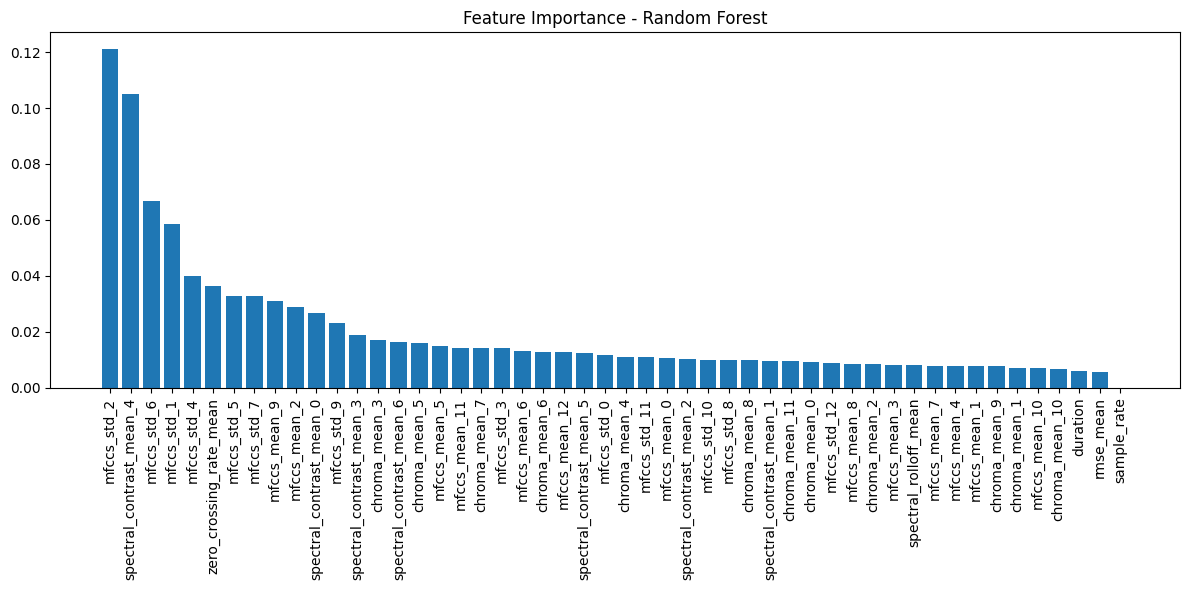

In [48]:
import matplotlib.pyplot as plt

importances = best_rf_model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances[sorted_idx])
plt.xticks(range(len(importances)), feature_names[sorted_idx], rotation=90)
plt.title("Feature Importance - Random Forest")
plt.tight_layout()
plt.show()


In [49]:
import joblib

joblib.dump(best_rf_model, 'best_rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl') 


['scaler.pkl']

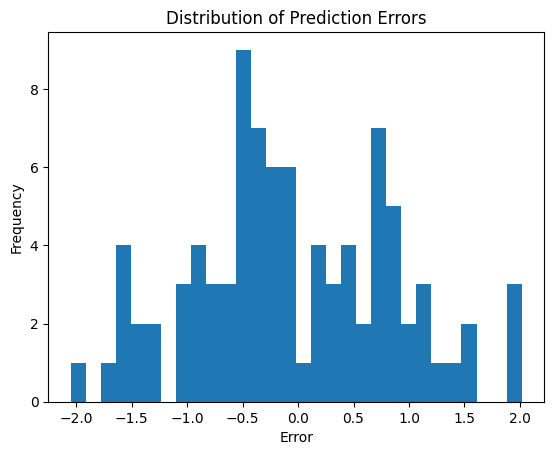

In [51]:
errors = y_test - best_rf_pred
plt.hist(errors, bins=30)
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()


# For Test Datasrt

In [53]:
model = joblib.load('/kaggle/working/best_rf_model.pkl')  # update path if needed

# Load Test Data

In [98]:
test_df = pd.read_csv('/kaggle/input/shl-intern-hiring-assessment/dataset/test.csv')

test_audio_dir = '/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/'

In [99]:
def extract_audio_features(file_path):
    y, sr = librosa.load(file_path, sr=None)

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)

    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)

    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spectral_contrast_mean = np.mean(spectral_contrast, axis=1)

    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
    zero_crossing_rate_mean = np.mean(zero_crossing_rate)

    rmse = librosa.feature.rms(y=y)
    rmse_mean = np.mean(rmse)

    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)
    spectral_rolloff_mean = np.mean(spectral_rolloff)

    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)

    return [mfccs_mean, mfccs_std, chroma_mean, spectral_contrast_mean, 
                      zero_crossing_rate_mean, rmse_mean, spectral_rolloff_mean, tempo]

In [100]:
test_audio_dir = '/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/'

test_df = pd.read_csv('/kaggle/input/shl-intern-hiring-assessment/dataset/test.csv')

In [101]:
test_df.head()

,filename
0,audio_706.wav
1,audio_800.wav
2,audio_68.wav
3,audio_1267.wav
4,audio_683.wav


# extracting the same feature

In [110]:
test_sample_rates = []

for file_name in tqdm(test_files): 
    file_path = os.path.join(test_audio_dir, file_name)
    _, sr = librosa.load(file_path, sr=None)
    test_sample_rates.append(sr)  

test_sample_rates = np.array(test_sample_rates)

100%|██████████| 195/195 [00:02<00:00, 89.80it/s] 


In [113]:
test_durations = []


for file_name in tqdm(test_files): 
    file_path = os.path.join(test_audio_dir, file_name)
    y, sr = librosa.load(file_path, sr=None) 
    duration = librosa.get_duration(y=y, sr=sr)  
    test_durations.append(duration) 

test_durations = np.array(test_durations)

100%|██████████| 195/195 [00:02<00:00, 87.85it/s] 


In [114]:
test_df['duration'] = test_durations  
test_df['sample_rate'] = test_sample_rates  


In [92]:
X_test = []
for file_name in tqdm(test_files):
    file_path = os.path.join(test_audio_dir, file_name)
    features = extract_audio_features(file_path)
    X_test.append(features)

100%|██████████| 195/195 [02:19<00:00,  1.40it/s]


In [93]:
print(len(audio_features[0])) 


8


In [94]:
print(len(X_test[0]))

8


same => no issue

In [115]:
test_features_df = pd.DataFrame(X_test, columns=['mfccs_mean', 'mfccs_std', 'chroma_mean', 
                                                 'spectral_contrast_mean', 'zero_crossing_rate_mean',
                                                 'rmse_mean', 'spectral_rolloff_mean', 'tempo'])


In [116]:
test_data = pd.concat([test_df, test_features_df], axis=1)

In [117]:
test_data.drop(columns='tempo', inplace=True)

In [118]:
test_data.shape

(195, 10)

In [122]:
audioc.shape # label and tempo extra

(444, 12)

In [119]:
test_data.head()

,filename,duration,sample_rate,mfccs_mean,mfccs_std,chroma_mean,spectral_contrast_mean,zero_crossing_rate_mean,rmse_mean,spectral_rolloff_mean
0,audio_706.wav,60.074688,16000,"[-340.82147, 87.85408, -27.584362, 20.225647, ...","[80.33938, 38.27538, 18.949009, 28.317982, 11....","[0.4512049, 0.42323378, 0.4595932, 0.40220132,...","[18.401672540283943, 16.614784926400436, 17.97...",0.150859,0.031372,3048.963325
1,audio_800.wav,60.074688,16000,"[-320.66348, 99.58227, -35.04238, 20.576435, 6...","[67.099495, 36.341797, 20.240795, 24.234306, 1...","[0.45543918, 0.38863558, 0.40902305, 0.3436752...","[18.312427100551947, 16.444551824967203, 17.90...",0.150618,0.033988,2924.828608
2,audio_68.wav,61.034687,16000,"[-384.16974, 140.47226, 15.962435, 14.047473, ...","[106.80507, 75.61109, 38.71663, 34.33046, 24.6...","[0.38452804, 0.378024, 0.37199846, 0.34308976,...","[23.979458818742806, 17.219162416887123, 20.42...",0.136084,0.054290,2389.933012
3,audio_1267.wav,54.080000,16000,"[-353.7339, 68.909996, -21.333244, 21.156925, ...","[157.80261, 52.0915, 39.417286, 28.889921, 21....","[0.33445385, 0.3757705, 0.37878117, 0.46784645...","[22.74841320029089, 18.67655956913452, 21.5207...",0.210088,0.050933,3880.373115
4,audio_683.wav,60.074688,16000,"[-381.19275, 129.61012, 12.445641, 19.765879, ...","[87.90278, 49.902298, 23.529728, 25.093761, 14...","[0.45215914, 0.2779441, 0.18397126, 0.14116377...","[20.733929426104382, 17.94272458901041, 20.853...",0.077122,0.040125,2762.783713


In [126]:
def expand_column(df, col_name):
    return pd.DataFrame(df[col_name].tolist(), index=df.index).add_prefix(col_name + "_")
    
# Expanding the feature columns
test_expanded = pd.concat([
    expand_column(test_data, 'mfccs_mean'),
    expand_column(test_data, 'mfccs_std'),
    expand_column(test_data, 'chroma_mean'),
    expand_column(test_data, 'spectral_contrast_mean'),
], axis=1)

# Scalar columns
scalar_cols = ['zero_crossing_rate_mean', 'rmse_mean', 'spectral_rolloff_mean',  'duration', 'sample_rate']

# Final DataFrame with features
test_final = pd.concat([test_expanded, test_data[scalar_cols]], axis=1)


In [127]:
test_final.shape

(195, 50)

In [128]:
audioc_final.shape # label extra

(444, 51)

# Noramalise with same scale

In [129]:
test_scaled = scaler.transform(test_final)

In [130]:
model = joblib.load('best_rf_model.pkl')

predictions = model.predict(test_scaled)

# Creating Submission File

In [131]:
submission = pd.DataFrame({
    'filename': test_df['filename'], 
    'label': predictions.astype(float)

# Save to CSV
submission.to_csv('submission.csv', index=False)
print("✅ Submission file 'submission.csv' created.")


✅ Submission file 'submission.csv' created.
